# Introduction

This project aims to discover hidden patterns in the Titanic training dataset and create a model to predict survival of each passanger in the test dataset. 

In [1]:
# Import Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# NLP libraries
import re  # Regular expressions library for pattern matching

# Statistics
from statistics import mode

# Preprocessing and Evaluation
from sklearn.preprocessing import MinMaxScaler #, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, confusion_matrix

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB


# 1. Data Cleaning

### 1.1 Loading The Data

In [2]:
# Import the datasets and assign them into the dataframes
train_df = pd.read_csv('train.csv')

### 1.2 Data Exploration

In [3]:
print('Shape of the dataframe')
print(train_df.shape)

Shape of the dataframe
(891, 12)


It's not a huge data. Hence we need to find the best models that have thew highest performance with small amount of data.

In [4]:
print('Columns of the dataframe')
print(train_df.columns)

Columns of the dataframe
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [5]:
print('The First 5 rows of the dataframe')
train_df.head()

The First 5 rows of the dataframe


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
print('General Info of the dataframe')
print(train_df.info())

General Info of the dataframe
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [7]:
train_df.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

##### We can effortlessly employ Pclass, Sex, SibSp, Parch, and Embarked as categorical variables without the need for extensive column transformations.

In [8]:
# Checking the SibSp column by grouping its values
train_df.groupby('SibSp').size()

SibSp
0    608
1    209
2     28
3     16
4     18
5      5
8      7
dtype: int64

## 1.3. Test Data

In [9]:
# Import Test Data
test_df = pd.read_csv('test.csv')

In [10]:
test_df.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

##### test_df shares identical columns with train_df.

In [11]:
# Merge training and test data
# Hence, we can apply data cleaning process for both of them at once.
df = pd.concat([train_df, test_df], axis=0)

## 1.4 Dealing with Nulls

In [12]:
df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

##### As presented above, there are null values for 4 feature column. We will be dealing with them one by one.

### 1.4.1 Age

C:\Users\tolga\AppData\Local\Temp\ipykernel_8244\41410854.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


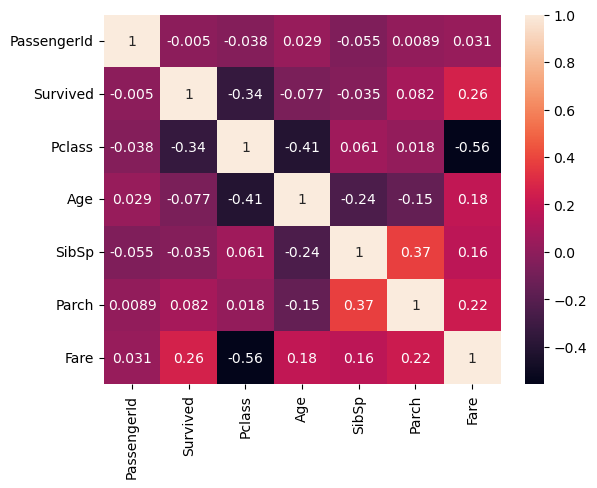

In [13]:
sns.heatmap(df.corr(), annot=True)
plt.show()

# As seen below, Age is negatively and slightly correlated with Pclass and SibSp columns.

In [14]:
df.groupby('Sex')['Age'].mean()

Sex
female    28.687088
male      30.585228
Name: Age, dtype: float64

##### As seen above, females in the ship are slightly younger than males.

In [15]:
df.groupby('SibSp')['Age'].mean()

SibSp
0    30.921766
1    31.058071
2    23.569444
3    16.312500
4     8.772727
5    10.166667
8    14.500000
Name: Age, dtype: float64

##### As observed earlier, age exhibits significant variations depending on the number of siblings and the spouse number.

In [16]:
# Calculate the mean age for each group defined by other features
df['Age'] = df.groupby(['Sex', 'SibSp'])['Age'].transform(lambda x: x.fillna(x.mean()))

In [17]:
# We can just fill the remaining null values with average age.
df['Age'] = df['Age'].fillna(df['Age'].mean())

### 1.4.2 Cabin

In [18]:
df.groupby('Cabin').size().sort_values()

Cabin
A10                1
D38                1
D34                1
D22                1
D11                1
                  ..
F4                 4
C78                4
B57 B59 B63 B66    5
G6                 5
C23 C25 C27        6
Length: 186, dtype: int64

We will address the Cabin later by creating features based on the letters in the cabin column. 
Considering the high number of null values in the column, we can incorporate them as a feature, as they may convey valuable information.

In [19]:
# Let's label null values as "N"
df['Cabin'] = df['Cabin'].fillna('N')

### 1.4.3 Embarked

In [20]:
df.groupby('Embarked').size().sort_values()
# The most frequent value in Embarked column is "S".\
# Hence , we can fill two null values with "S"

Embarked
Q    123
C    270
S    914
dtype: int64

In [21]:
# Finding the mode of 'Embarked' column
mode_embarked = df['Embarked'].mode().iloc[0]
# Filling null values in the embarked column with the mode.
df['Embarked'] = df['Embarked'].fillna(mode_embarked)

### 1.4.4 Fare

C:\Users\tolga\AppData\Local\Temp\ipykernel_8244\221941791.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


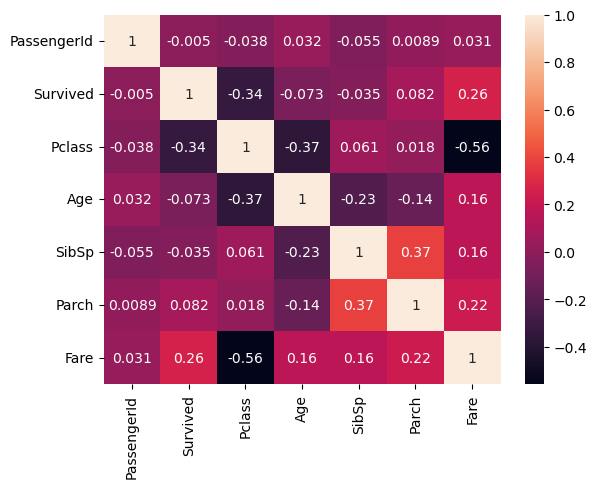

In [22]:
sns.heatmap(df.corr(), annot=True)
plt.show()

As seen in the above heatmap, Fare is correlated with Pclass.

In [23]:
df.groupby('Pclass')['Fare'].mean()

Pclass
1    87.508992
2    21.179196
3    13.302889
Name: Fare, dtype: float64

In [24]:
# Calculate the mean age for each Pclass group
df['Fare'] = df.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.mean()))

In [25]:
# Last control
df.isnull().sum()

PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin            0
Embarked         0
dtype: int64

As seen above, there are no null values within the features.

# 2. Feature Engineering

## 2.1. Name Column

In [26]:
# Create an empty list to store cleaned 'Name' features.
title_list = []

# Loop through each row in the 'Name' column of the dataframe.
for text in df['Name']:
    splited = text.split(',')
    title = splited[1].split()[0]
    # Remove special characters
    title = re.sub(r'[^\w\s]', '', title)
    
    # Grouping military titles
    if title in ['Capt', 'Col', 'Major']:
        title = 'Military'
    # Grouping miss titles
    elif title in ['Ms', 'Mlle']:
        title = 'Miss'
    # Grouping Mrs titles
    elif title in ['Mme', 'Lady', 'the']:
        title = 'Mrs'
    # Grouping honorofic titles
    elif title in ['Sir', 'Don', 'Jonkheer', 'Rev', 'Dr', 'Dona']:
        title = 'Honorary '
    title_list.append(title)
    
# Create a column named 'Title' in the dataframe that contains cleaned and grouped titles.
df['Title'] = title_list

# Drop the "Name" column
df.drop(columns=['Name'], inplace=True)

In [27]:
df.groupby('Title').size().sort_values(ascending=True)

Title
Military       7
Honorary      20
Master        61
Mrs          200
Miss         264
Mr           757
dtype: int64

## 2.2. Cabin Column

In [28]:
cabin_list = []

for item in df['Cabin'].items():
    text = item[1]
    # Remove digit characters
    cabin = re.sub(r'\d+', ' ', text)
    # Find the most repeated letter
    mode_cabin = mode(cabin.split())
    # Append the cabin list with the most repeated letter
    cabin_list.append(mode_cabin)

# Update the "cabin" column with cabin_list
df['Cabin'] = cabin_list

In [29]:
df.groupby('Cabin').size().sort_values(ascending=True)

Cabin
T       1
G       5
F      21
A      22
E      41
D      46
B      65
C      94
N    1014
dtype: int64

## 2.3. PassengerId and Ticket

In [30]:
# Due to their high number of uniqueness, we can not extract enough information from
# PassenderId and Ticket columns.
# Hence, We can drop them.

df.drop(columns=['PassengerId', 'Ticket'], inplace=True)

## 2.4. Encoding the Categorical Variables

In [31]:
# Select the categorical columns
columns_ = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Cabin', 'Embarked', 'Title']

# Perform one-hot encoding
df = pd.get_dummies(df, columns=columns_)

In [32]:
# All the categorical columns are encoded and numeric
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 41 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Survived         891 non-null    float64
 1   Age              1309 non-null   float64
 2   Fare             1309 non-null   float64
 3   Pclass_1         1309 non-null   uint8  
 4   Pclass_2         1309 non-null   uint8  
 5   Pclass_3         1309 non-null   uint8  
 6   Sex_female       1309 non-null   uint8  
 7   Sex_male         1309 non-null   uint8  
 8   SibSp_0          1309 non-null   uint8  
 9   SibSp_1          1309 non-null   uint8  
 10  SibSp_2          1309 non-null   uint8  
 11  SibSp_3          1309 non-null   uint8  
 12  SibSp_4          1309 non-null   uint8  
 13  SibSp_5          1309 non-null   uint8  
 14  SibSp_8          1309 non-null   uint8  
 15  Parch_0          1309 non-null   uint8  
 16  Parch_1          1309 non-null   uint8  
 17  Parch_2        

## 2.5 Data normalization

In [33]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()
    
# Normalize all the columns but "Survived", which is the target variable
df[df.columns[1:]] = scaler.fit_transform(df[df.columns[1:]])


# 3. Feature Selection

### 3.1 Calculate correlation between Survived and independent variables using 
#### Pearson correlation
#### Spearman correlation
#### Kendall correlation

In [34]:
def correlation_analysis(data, target, threshold=0.2):
    # Pearson correlation
    pearson_corr = data.corr(method='pearson')[target].abs()
    pearson_features = pearson_corr[pearson_corr >= threshold].index.tolist()

    # Spearman correlation
    spearman_corr = data.corr(method='spearman')[target].abs()
    spearman_features = spearman_corr[spearman_corr >= threshold].index.tolist()

    # Kendall correlation
    kendall_corr = data.corr(method='kendall')[target].abs()
    kendall_features = kendall_corr[kendall_corr >= threshold].index.tolist()

    return pearson_features, spearman_features, kendall_features

# Example usage
target = "Survived"
threshold = 0.2
pearson_features, spearman_features, kendall_features = correlation_analysis(df, target, threshold)

print("Features selected using Pearson correlation:")
print(pearson_features)

print("Features selected using Spearman correlation:")
print(spearman_features)

print("Features selected using Kendall correlation:")
print(kendall_features)

Features selected using Pearson correlation:
['Survived', 'Fare', 'Pclass_1', 'Pclass_3', 'Sex_female', 'Sex_male', 'Cabin_N', 'Title_Miss', 'Title_Mr', 'Title_Mrs']
Features selected using Spearman correlation:
['Survived', 'Fare', 'Pclass_1', 'Pclass_3', 'Sex_female', 'Sex_male', 'Cabin_N', 'Title_Miss', 'Title_Mr', 'Title_Mrs']
Features selected using Kendall correlation:
['Survived', 'Fare', 'Pclass_1', 'Pclass_3', 'Sex_female', 'Sex_male', 'Cabin_N', 'Title_Miss', 'Title_Mr', 'Title_Mrs']


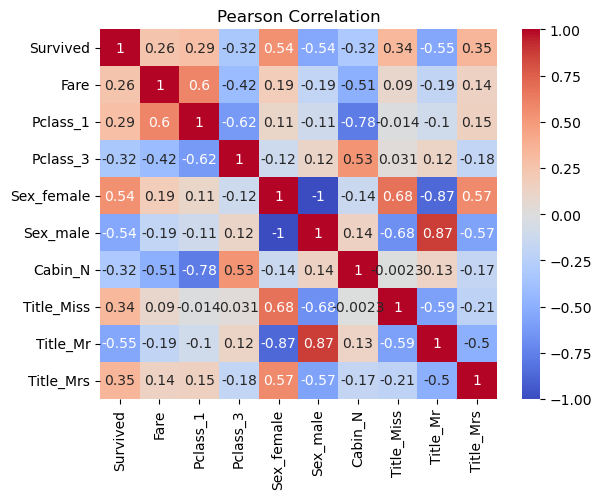

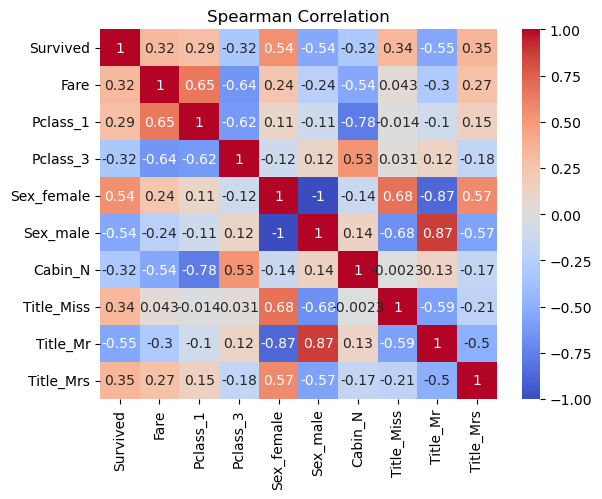

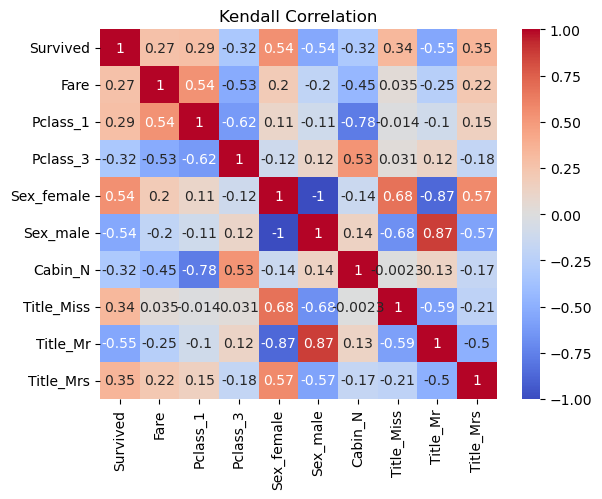

In [35]:
def correlation_heatmap(data, features, correlation_method):
    # Calculate correlation matrix
    corr_matrix = data[features].corr(method=correlation_method)

    # Create heatmap
    sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)

    # Set the title of the heatmap
    plt.title(f"{correlation_method.capitalize()} Correlation")

    # Display the heatmap
    plt.show()
    
# Select the features and correlation method based on the extracted features
if len(pearson_features) > 0:
    selected_features = pearson_features
    correlation_method = 'pearson'
elif len(spearman_features) > 0:
    selected_features = spearman_features
    correlation_method = 'spearman'
elif len(kendall_features) > 0:
    selected_features = kendall_features
    correlation_method = 'kendall'
else:
    print("No features extracted.")

# Create a correlation heatmap for the selected features using the corresponding correlation method
correlation_heatmap(df, pearson_features, 'pearson')
correlation_heatmap(df, spearman_features, 'spearman')
correlation_heatmap(df, kendall_features, 'kendall')

In [36]:
# Filter the most correlated features and target variable for the models

columns = ['Survived'
           , 'Fare'
           , 'Pclass_1'
           , 'Pclass_3'
           , 'Sex_female'
           , 'Sex_male'
           , 'Cabin_N'
           , 'Title_Miss'
           , 'Title_Mr'
           , 'Title_Mrs']

df_model = df[columns]

# 4. Model Development And Evaluation

In this section, we will craft eight classification models: Logistic Regression, Decision Tree Classifier, Random Forest Classifier, KNN, SVC, XG Boost Classifier, Gradient Boosting Classifier and Multinominal NB. Subsequently, we will establish a pipeline and create a parameter dictionary to outline the hyperparameters for each model. Following this, we will utilize GridSearchCV to systematically fit and evaluate each model across a range of hyperparameter combinations. Finally, we will delve into a comprehensive discussion of the results obtained through this process.

## 4.1. Train Test Split

In [37]:
# Define dependent and independent variables
y = df_model['Survived'].iloc[:891]
X = df_model.iloc[:891, 1:]

# Define the dataframe that we will use for prediction after finding the best model and parameters
X_to_test = df_model.iloc[891:, 1:]

In [38]:
# Split the data into train and test
# Random state has been set to 42 in order to get the same training and testing seperation.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## 4.2. Initialize the Models

In [39]:
lr =  LogisticRegression(random_state=42)
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)
knn = KNeighborsClassifier()
svm = svm.SVC(random_state=42)
xgb = XGBClassifier(random_state=42)
gbc = GradientBoostingClassifier(random_state=42)
mnb = MultinomialNB()

## 4.3. Initialize the Hyper-parameters

In [40]:
# Parameters for LogisticRegression
lr_param = {}
lr_param['Classifier'] = [lr]
lr_param['Classifier__penalty'] = ['l1', 'l2']
lr_param['Classifier__C'] = [1.0, 0.5, 0.1]
lr_param['Classifier__solver'] = ['liblinear']

# Parameters for DEcisionTree
dt_param = {}
dt_param['Classifier'] = [dt]
dt_param['Classifier__criterion'] = ['gini', 'entropy']
dt_param['Classifier__min_samples_leaf'] = [1, 2, 3, 4, 5, 6]
dt_param['Classifier__max_depth'] = [1, 2, 3, 4, 5, 6]
dt_param['Classifier__min_samples_split'] = [2, 3, 4, 5, 6]

# Parameters for RandomForest
rf_param = {}
rf_param['Classifier'] = [rf]
rf_param['Classifier__min_samples_leaf'] = [1, 2, 3, 4, 5, 6]
rf_param['Classifier__max_depth'] = [1, 2, 3, 4, 5, 6]
rf_param['Classifier__min_samples_split'] = [2, 3, 4, 5, 6]
rf_param['Classifier__n_estimators'] = [50,100,150]


# Parameters for KNN
knn_param = {}
knn_param['Classifier'] = [knn]
knn_param['Classifier__n_neighbors'] = [1, 2, 3, 4, 5, 6]
knn_param['Classifier__weights'] = ['uniform', 'distance']
knn_param['Classifier__metric'] = ['euclidean', 'manhattan']

# Parameters for SVM
svm_param = {}
svm_param['Classifier'] = [svm]
svm_param['Classifier__kernel'] = ['linear', 'rbf']
svm_param['Classifier__C'] = [1, 2, 3, 4, 5, 6]

# Parameters for XGBoost
xgb_param = {}
xgb_param['Classifier'] = [xgb]
xgb_param['Classifier__learning_rate'] = [.1,.15,.2,.25,.3]
xgb_param['Classifier__max_depth'] = [1, 2, 3, 4, 5, 6]
xgb_param['Classifier__min_child_weight'] = [1, 2, 3, 4, 5, 6]
xgb_param['Classifier__subsample'] = [1.0, 0.75, 0.5, 0.25, 0.1]
xgb_param['Classifier__n_estimators'] = [50, 80, 100, 120, 150]

# Parameters for GradientBoostingClassifier
gbc_param = {}
gbc_param['Classifier'] = [gbc]
gbc_param['Classifier__learning_rate'] = [.1,.2,.3]
gbc_param['Classifier__max_depth'] = [1, 2, 3, 4, 5, 6]
gbc_param['Classifier__loss'] = ['log_loss', 'deviance', 'exponential']
gbc_param['Classifier__subsample'] = [1.0, 0.5, 0.1]
gbc_param['Classifier__n_estimators'] = [50,100,150]

# Parameters for MultinomialNB
mnb_param = {}
mnb_param['Classifier'] = [mnb]
mnb_param['Classifier__alpha'] = [1, 10, 100]

In [41]:
# Create the pipeline
pipeline = Pipeline([('Classifier', dt)])
params = [lr_param, dt_param, rf_param, knn_param, svm_param, xgb_param, gbc_param, mnb_param]

## 4.4. GridSearchCV and Evaluation

In [42]:
%%time
 
# Run the GridSearchCV
grid_search = GridSearchCV(pipeline, params, cv = 5, scoring = 'roc_auc', verbose = 3, n_jobs= -1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 5931 candidates, totalling 29655 fits
CPU times: total: 32.5 s
Wall time: 4min 6s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Classifier',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'Classifier': [LogisticRegression(random_state=42)],
                          'Classifier__C': [1.0, 0.5, 0.1],
                          'Classifier__penalty': ['l1', 'l2'],
                          'Classifier__solver': ['liblinear']},
                         {'Classifier': [DecisionTreeClassifier(random_state=42)],
                          'Classifier__criter...
                         {'Classifier': [GradientBoostingClassifier(random_state=42)],
                          'Classifier__learning_rate': [0.1, 0.2, 0.3],
                          'Classifier__loss': ['log_loss', 'deviance',
                                               'exponential'],
                          'Classifier__max_depth': [1, 2, 3, 4, 5, 6],
                          'Classifier__n_estimators': [50, 100, 150],
                          'Classifier__subsample': [1.0, 0.5, 0.1]},
                         {'Classifier': [MultinomialNB()],
                          'Classifier__alpha': [1, 10, 100]}],
             scoring='roc_auc', verbose=3)

In [43]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print('best model: ' +str(best_model))
print('best parameters: ' +str(best_params))
print('best score: ' +str(best_score))

best model: Pipeline(steps=[('Classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.15,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None, min_child_weight=4,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=100,
                  

In [45]:
df_results_ = pd.DataFrame(grid_search.cv_results_)

In [46]:
df_results_[df_results_['rank_test_score']==1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_Classifier,param_Classifier__C,param_Classifier__penalty,param_Classifier__solver,param_Classifier__criterion,param_Classifier__max_depth,...,param_Classifier__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2529,0.062047,0.008705,0.004321,0.006107,"XGBClassifier(base_score=None, booster=None, c...",NaN,NaN,NaN,NaN,5,...,NaN,"{'Classifier': XGBClassifier(base_score=None, ...",0.866001,0.887849,0.864639,0.872907,0.876263,0.873531,0.00835,1


In [47]:
print(df_results_.loc[2529]['params'])

{'Classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...), 'Classifier__learning_rate': 0.15, 'Classifier__max_depth': 5, 'Classifier__min_child_weight': 4, 'Classifier__n_estimators': 100, 'Classifier__subsample': 0.5}


As seen above, the best model is XG Boost Classifier. Also, the best parameters are presented above.

## 4.5 Train and Test the Best Model

In [48]:
# Define the best model, which is XG Boost Classifier with the best parameters
xgbc = XGBClassifier(learning_rate = 0.15
                            , max_depth = 5
                            , min_child_weight = 4
                            , n_estimators = 100
                            , subsample = 0.5)
# Train the model
xgbc.fit(X_train, y_train)
# Predict testing dataset
y_pred = xgbc.predict(X_test)

In [49]:
# Evaluation of test results
precision_score_ = precision_score(y_test, y_pred)
accuracy_ = roc_auc_score(y_test, y_pred)

print('precision_score_: '+str(precision_score_))
print('accuracy_: '+str(accuracy_))

precision_score_: 0.7916666666666666
accuracy_: 0.8137065637065637


## 4.6 Visualization of Results

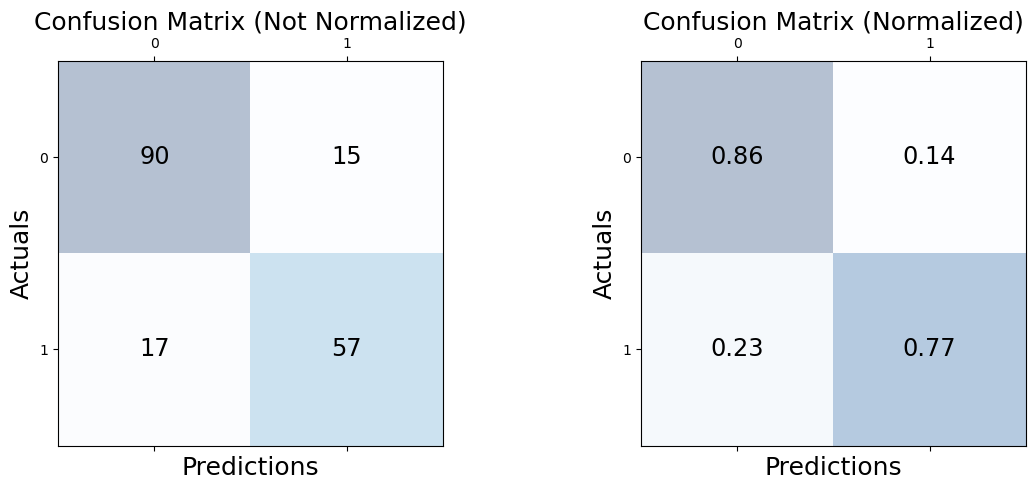

In [50]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

# Plotting the Confusion Matrix without normalization
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot without normalization
ax[0].matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax[0].text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

ax[0].set_xlabel('Predictions', fontsize=18)
ax[0].set_ylabel('Actuals', fontsize=18)
ax[0].set_title('Confusion Matrix (Not Normalized)', fontsize=18)

# Plotting the Confusion Matrix with normalization
normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot with normalization
im = ax[1].matshow(normalized_conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(normalized_conf_matrix.shape[0]):
    for j in range(normalized_conf_matrix.shape[1]):
        ax[1].text(x=j, y=i, s=f'{normalized_conf_matrix[i, j]:.2f}', va='center', ha='center', size='xx-large')

ax[1].set_xlabel('Predictions', fontsize=18)
ax[1].set_ylabel('Actuals', fontsize=18)
ax[1].set_title('Confusion Matrix (Normalized)', fontsize=18)


plt.tight_layout()
plt.show()

## 4.7. Predicting Test Data for Submission

In [51]:
# Predict the target variable for the submission
y_to_test = xgbc.predict(X_to_test)
# Create the data frame for the submission
submission_df = pd.DataFrame(test_df['PassengerId'])
submission_df['Survived'] = y_to_test
# Export the dataframe to a csv file
submission_df.to_csv('submission.csv', index=False)